In [41]:
import numpy as np 
import pandas as pd 
import random


import os
import glob


from PIL import Image


import matplotlib.pyplot as plt
plt.rc('image', cmap='hsv')


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
categories = ["NORMAL", "PNEUMONIA"]
datasets = ["train", "test", "val"]

In [43]:
#glob.glob('C:\\Users\\김주빈\\project\\Damion\\project\\Chest X-Ray Images (Pneumonia)\\chest_xray\\*')

In [44]:
%%time

widths = []
heights = []

for set_ in datasets:
    for cat in categories:
        filelist = glob.glob('C:\\Users\\김주빈\\chest_xray\\'+ set_ + '/' + cat + '/*.jpeg')
        widths.extend([Image.open(fname).size[0] for fname in filelist])
        heights.extend([Image.open(fname).size[1] for fname in filelist])

images_size = pd.DataFrame({"widths": widths, "heights": heights})
        
print("Average image width: " + f'{images_size["widths"].mean():.2f}')
print("Average image height: " + f'{images_size["heights"].mean():.2f}')

Average image width: 1327.88
Average image height: 970.69
Wall time: 2.21 s


In [45]:
im_width = 224
im_height = 224
print("image width: " + str(im_width))
print("image height: " + str(im_height))

image width: 224
image height: 224


In [46]:
%%time

data = []
target = []

for set_ in datasets:
    for cat in categories:
        filelist = glob.glob('C:\\Users\\김주빈\\chest_xray\\'+ set_ + '/' + cat + '/*.jpeg')
        target.extend([cat for _ in filelist])
        data.extend([np.array(Image.open(fname).convert('L').resize((im_width, im_height))) for fname in filelist])
#
data_array = np.stack(data, axis=0)
target = np.array(target)

Wall time: 48.6 s


In [47]:
print(data_array.shape)
print(target)

(5856, 224, 224)
['NORMAL' 'NORMAL' 'NORMAL' ... 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA']


In [48]:
pd.concat([pd.DataFrame(pd.DataFrame({"target" : target}).value_counts()).rename(columns={0:"count"}),
           pd.DataFrame(pd.DataFrame(target).value_counts()*100/len(target)).applymap(round).rename(columns={0:"%"})], axis=1)

,count,%
PNEUMONIA,4273,73
NORMAL,1583,27


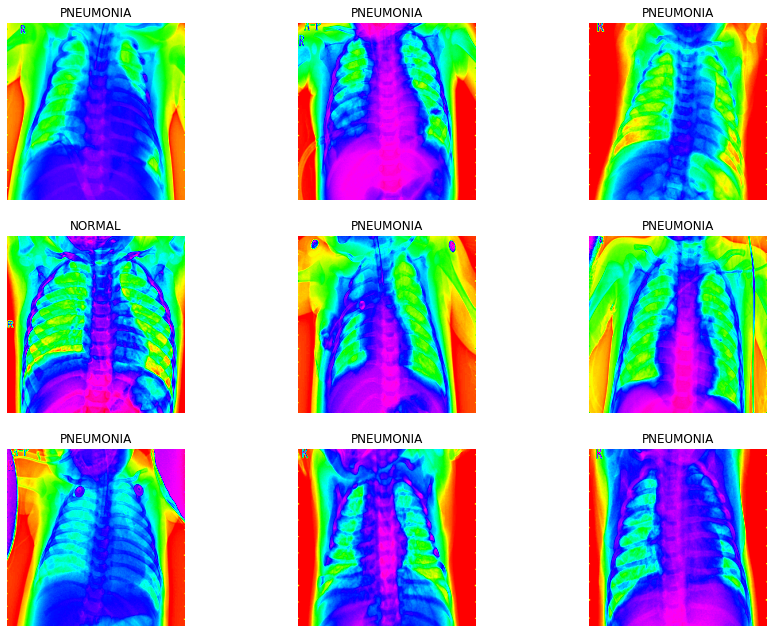

In [49]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, data_array.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(target[num_image])
        ax.imshow(data_array[num_image]);

In [51]:
X_train, X_test, y_train, y_test = train_test_split(data_array, target, random_state = 43, test_size = 0.2, stratify=target)

In [52]:
print(X_train.shape)
print(y_train.shape)

(4684, 224, 224)
(4684,)


In [53]:
pd.DataFrame(y_train).value_counts()/len(y_train)
pd.DataFrame().value_counts()/len(y_train)

Series([], dtype: float64)

In [54]:
#정규화 (0에서 1까지 픽셀값 조정)
X_test_norm = np.round((X_test/255), 3).copy()
X_train_norm = np.round((X_train/255), 3).copy()

In [55]:
encoder = LabelEncoder()

In [56]:
y_train_cat = encoder.fit_transform(y_train)
y_test_cat = encoder.fit_transform(y_test)

In [57]:
print(y_train[:3])
print(y_train_cat[:3])

['PNEUMONIA' 'NORMAL' 'NORMAL']
[1 0 0]


In [64]:
X_train_norm = X_train_norm.reshape(-1, 1,224,224)
X_test_norm = X_test_norm.reshape(-1, 1,224,224)
X_train_norm.shape

(4684, 1, 224, 224)

In [59]:
import h5py
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Concatenate
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D


def SqueezeNet(nb_classes, inputs=(3,224, 224)):
    """ Keras Implementation of SqueezeNet(arXiv 1602.07360)
    @param nb_classes: total number of final categories
    Arguments:
    inputs -- shape of the input images (channel, cols, rows)
    """

    input_img = Input(shape=inputs)
    conv1 = Convolution2D(
        96, (7, 7), activation='relu', kernel_initializer='glorot_uniform',
        strides=(2, 2), padding='same', name='conv1',
        data_format="channels_first")(input_img)
    maxpool1 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool1',
        data_format="channels_first")(conv1)
    fire2_squeeze = Convolution2D(
        16, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire2_squeeze',
        data_format="channels_first")(maxpool1)
    fire2_expand1 = Convolution2D(
        64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire2_expand1',
        data_format="channels_first")(fire2_squeeze)
    fire2_expand2 = Convolution2D(
        64, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire2_expand2',
        data_format="channels_first")(fire2_squeeze)
    merge2 = Concatenate(axis=1)([fire2_expand1, fire2_expand2])

    fire3_squeeze = Convolution2D(
        16, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire3_squeeze',
        data_format="channels_first")(merge2)
    fire3_expand1 = Convolution2D(
        64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire3_expand1',
        data_format="channels_first")(fire3_squeeze)
    fire3_expand2 = Convolution2D(
        64, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire3_expand2',
        data_format="channels_first")(fire3_squeeze)
    merge3 = Concatenate(axis=1)([fire3_expand1, fire3_expand2])

    fire4_squeeze = Convolution2D(
        32, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire4_squeeze',
        data_format="channels_first")(merge3)
    fire4_expand1 = Convolution2D(
        128, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire4_expand1',
        data_format="channels_first")(fire4_squeeze)
    fire4_expand2 = Convolution2D(
        128, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire4_expand2',
        data_format="channels_first")(fire4_squeeze)
    merge4 = Concatenate(axis=1)([fire4_expand1, fire4_expand2])
    maxpool4 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool4',
        data_format="channels_first")(merge4)

    fire5_squeeze = Convolution2D(
        32, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire5_squeeze',
        data_format="channels_first")(maxpool4)
    fire5_expand1 = Convolution2D(
        128, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire5_expand1',
        data_format="channels_first")(fire5_squeeze)
    fire5_expand2 = Convolution2D(
        128, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire5_expand2',
        data_format="channels_first")(fire5_squeeze)
    merge5 = Concatenate(axis=1)([fire5_expand1, fire5_expand2])

    fire6_squeeze = Convolution2D(
        48, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire6_squeeze',
        data_format="channels_first")(merge5)
    fire6_expand1 = Convolution2D(
        192, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire6_expand1',
        data_format="channels_first")(fire6_squeeze)
    fire6_expand2 = Convolution2D(
        192, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire6_expand2',
        data_format="channels_first")(fire6_squeeze)
    merge6 = Concatenate(axis=1)([fire6_expand1, fire6_expand2])

    fire7_squeeze = Convolution2D(
        48, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire7_squeeze',
        data_format="channels_first")(merge6)
    fire7_expand1 = Convolution2D(
        192, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire7_expand1',
        data_format="channels_first")(fire7_squeeze)
    fire7_expand2 = Convolution2D(
        192, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire7_expand2',
        data_format="channels_first")(fire7_squeeze)
    merge7 = Concatenate(axis=1)([fire7_expand1, fire7_expand2])

    fire8_squeeze = Convolution2D(
        64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire8_squeeze',
        data_format="channels_first")(merge7)
    fire8_expand1 = Convolution2D(
        256, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire8_expand1',
        data_format="channels_first")(fire8_squeeze)
    fire8_expand2 = Convolution2D(
        256, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire8_expand2',
        data_format="channels_first")(fire8_squeeze)
    merge8 = Concatenate(axis=1)([fire8_expand1, fire8_expand2])

    maxpool8 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool8',
        data_format="channels_first")(merge8)
    fire9_squeeze = Convolution2D(
        64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire9_squeeze',
        data_format="channels_first")(maxpool8)
    fire9_expand1 = Convolution2D(
        256, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire9_expand1',
        data_format="channels_first")(fire9_squeeze)
    fire9_expand2 = Convolution2D(
        256, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire9_expand2',
        data_format="channels_first")(fire9_squeeze)
    merge9 = Concatenate(axis=1)([fire9_expand1, fire9_expand2])

    fire9_dropout = Dropout(0.2, name='fire9_dropout')(merge9)
    conv10 = Convolution2D(
        nb_classes, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='valid', name='conv10',
        data_format="channels_first")(fire9_dropout)

    global_avgpool10 = GlobalAveragePooling2D(data_format='channels_first')(conv10)
    softmax = Activation("sigmoid", name='sigmoid')(global_avgpool10)

    return Model(inputs=input_img, outputs=softmax)

In [60]:
model = SqueezeNet(2, (3,224, 224))
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 3, 224, 224) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 96, 112, 112) 14208       input_4[0][0]                    
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 96, 55, 55)   0           conv1[0][0]                      
__________________________________________________________________________________________________
fire2_squeeze (Conv2D)          (None, 16, 55, 55)   1552        maxpool1[0][0]                   
_______________________________________________________________________________________

In [61]:
def compile_model(model):
    model.compile(optimizer='SGD',
                  loss='binary_crossentropy',
                  metrics="accuracy")
    return model

In [62]:
model = compile_model(model)
es = EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)

history = model.fit(X_train_norm, y_train_cat,
                    batch_size=25,
                    epochs=30,
                    validation_split=0.3,
                    callbacks=[es])

Epoch 1/30


ValueError: in user code:

    C:\Users\김주빈\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\김주빈\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\김주빈\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\김주빈\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\김주빈\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\김주빈\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\김주빈\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\김주빈\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\김주빈\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\Users\김주빈\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\김주빈\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\김주빈\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer conv1 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [None, 224, 224]


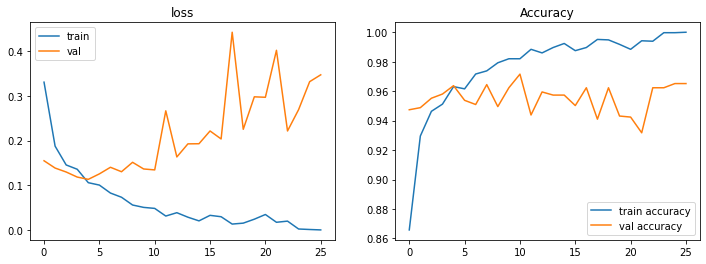

In [29]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(-0.1, 0.1)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.9, 1.1)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

plot_history(history, title='', axs=None, exp_name="");

In [30]:
model.evaluate(X_test_norm, y_test_cat, verbose=0)

[0.1493963748216629, 0.9590443968772888]

In [33]:
predictions = model.predict(X_test_norm)
print(predictions)

[[9.9953198e-01]
 [9.9999964e-01]
 [9.9999475e-01]
 ...
 [6.3517690e-04]
 [3.4366548e-03]
 [1.0000000e+00]]


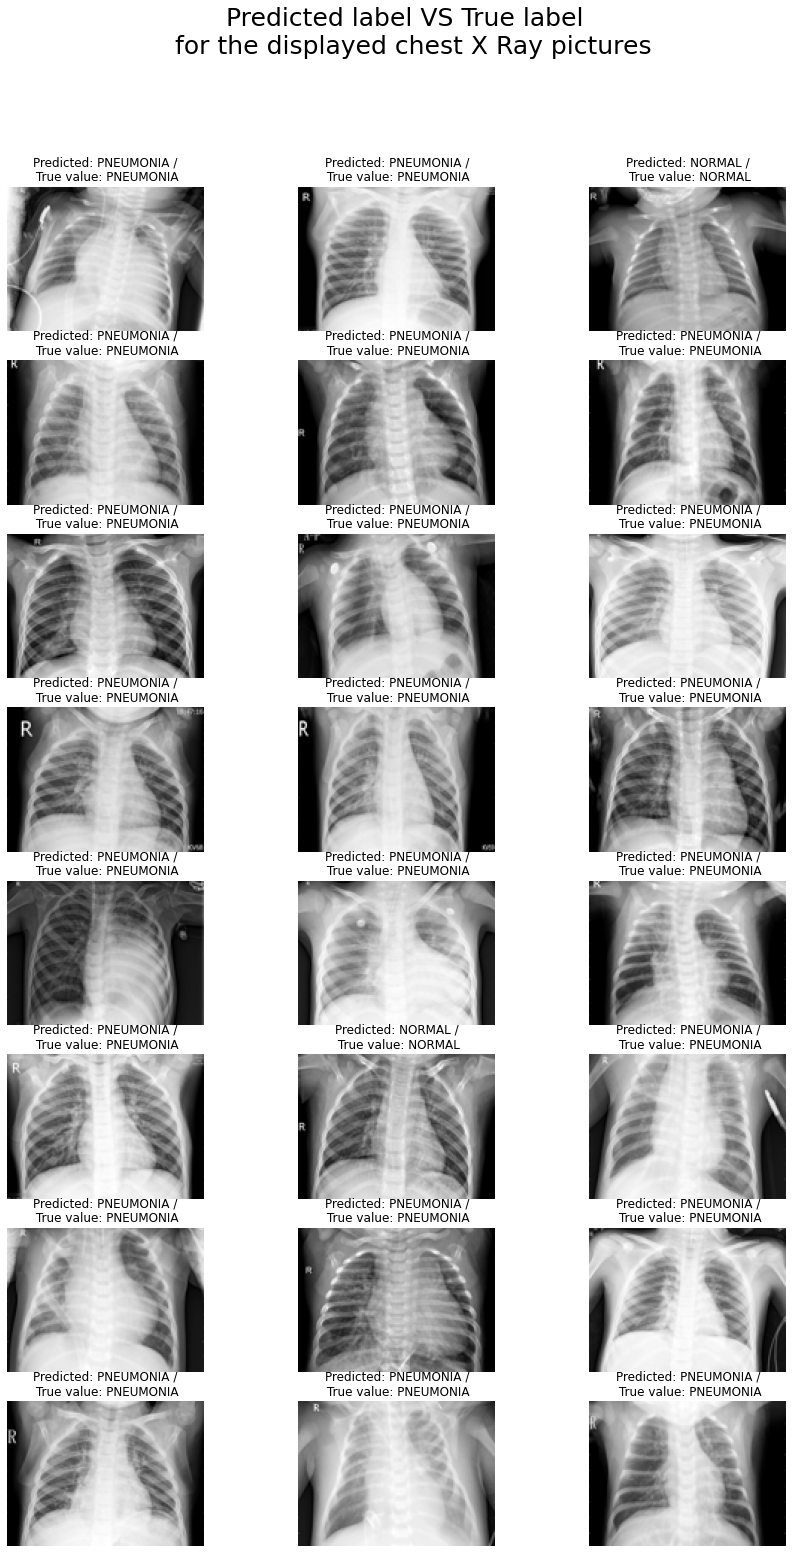

In [32]:
fig = plt.figure(figsize=(20,25))
gs = fig.add_gridspec(8, 4)
#
for row in range(0, 8):
    for col in range(0, 3):
        num_image = random.randint(0, X_test_norm.shape[0])
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title("Predicted: " + categories[int(np.round(predictions)[num_image][0])] + " /\n True value: " + categories[y_test_cat[num_image]])
        ax.imshow(X_test_norm[num_image]);
fig.suptitle("Predicted label VS True label \n for the displayed chest X Ray pictures", fontsize=25, x=0.42);
#plt.tight_layout;
